In [1]:
from os import system
system("pip install datasets")
system("pip install accelerate")
system("pip install evaluate")
system("pip install ray")
system("pip install tensorflow")
system("pip install tensorboardx")
system("pip install ipywidgets>=8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


0

In [2]:
from huggingface_hub import login
from os import system

system("git config --global credential.helper store")
token = "<token>"
login(token=token, add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
from transformers import AutoTokenizer

# defining labels
sentiment_labels = {0: "NEG", 1: "NEU", 2: "POS"}

# load pretrained model
model_name = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [4]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="/kaggle/input/vietnamese-sentiment-analyst/data.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
split_dataset = dataset["train"].train_test_split(test_size=0.2)

In [6]:
import numpy as np
from evaluate import load

metric = load("accuracy")
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))

list(metric.compute(predictions=fake_preds, references=fake_labels).values())[0]

2024-07-04 10:46:48.602190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 10:46:48.602317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 10:46:48.726558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


0.515625

In [7]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [8]:
show_random_elements(split_dataset["train"])

,content,label,start
0,"Thời gian giao hàng nhanh, chất lượng tốt phù hợp với giá tiền",POS,4
1,Hơi mặn,NEG,2
2,"Mặc vào rất gọn gàng, đứng áo",POS,5
3,Ko đep lam,NEG,1
4,Chất lượng sản phẩm tuyệt vời,POS,5
5,Vỏ dễ tách thật 👍,POS,4
6,Chất lượng sản phẩm tuyệt vời.Nhưng có 1 vết trầy nhỏ,POS,4
7,Đẹp lắm shop,POS,5
8,Để nguyên cái dây dài cả kilomet.hàng thì nhìn đẹp nhưng không biết dùng được bền không. nói chung bán hàng thì nên care khách chút,NEG,2
9,"Fom đẹp nhưng hơi mỏng, Thời gian giao hàng rất nhanh",POS,4


In [9]:
import numpy as np

# Filter label data
def change_label(example):
    index = list(sentiment_labels.values()).index(example['label'])
    example['label'] = np.zeros(3)
    example["label"][index] = 1
    return example

In [10]:
from os import system

system("pip install underthesea")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


0

In [11]:
none_dataset = split_dataset.map(change_label)
none_dataset = none_dataset.filter(lambda x: x["content"] != None)
show_random_elements(none_dataset["train"])

Map:   0%|          | 0/25168 [00:00<?, ? examples/s]

Map:   0%|          | 0/6292 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25168 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6292 [00:00<?, ? examples/s]

,content,label,start
0,"Ưng nhất là đóng gói cẩn thận , chắc chắn","[0.0, 0.0, 1.0]",5
1,Vải không dày và đứng form như hình,"[0.0, 1.0, 0.0]",3
2,Quần rất đẹp,"[0.0, 0.0, 1.0]",5
3,Sản phẩm Ko giống môn tả rách tùm lùm,"[1.0, 0.0, 0.0]",2
4,Nhận đc sản phẩm rất hài lòng,"[0.0, 0.0, 1.0]",5
5,Sản phẩm nào cũng rất ưng,"[0.0, 0.0, 1.0]",5
6,"M 54kg mà mặc rộng, phải đi sửa phần cổ lại, vì cúi xuống là hở ngực","[0.0, 1.0, 0.0]",3
7,Size ko chuẩn,"[1.0, 0.0, 0.0]",1
8,Thân dài thêo 1 tí là ok,"[0.0, 0.0, 1.0]",5
9,"Đúng form, vải ok nhưng hơi mỏng, với giá này thì OK :v","[0.0, 0.0, 1.0]",4


In [12]:
from transformers import AutoTokenizer
from underthesea import text_normalize

tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = max([len(sentence) for sentence in none_dataset["train"]["content"]])

def preprocess_function(sentence):
    return tokenizer(text_normalize(sentence["sentence"]), truncation=True, padding=True, max_length=max_length)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
none_dataset = none_dataset.remove_columns("start")
none_dataset = none_dataset.rename_column("content", "sentence")
encoded_dataset = none_dataset.map(preprocess_function)

Map:   0%|          | 0/25149 [00:00<?, ? examples/s]

Map:   0%|          | 0/6287 [00:00<?, ? examples/s]

In [14]:
from imblearn.over_sampling import ADASYN
from datasets import Dataset

minority_class = 1
df = encoded_dataset['train'].to_pandas()
sm = ADASYN(sampling_strategy={minority_class: 10000})
label = np.argmax(encoded_dataset['train']['label'], axis=1)
index_list,_ = sm.fit_resample([[x] for x in range(df.shape[0])], label)
index_list = [index for sublist in index_list for index in sublist]
new_df = df.iloc[index_list]
encoded_oversampled_dataset = Dataset.from_pandas(new_df)

In [15]:
from ray import tune
def ray_hp_space(trial):
    return {
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "neftune_noise_alpha": tune.choice([5,10,15,20]),
        'weight_decay': tune.loguniform(1e-6, 1e-4),
        'adam_beta1': tune.uniform(0.1, 0.9),
        'adam_beta2': tune.uniform(0.1, 0.999),
    }

2024-07-04 10:47:43,725	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-04 10:47:44,433	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [16]:
import wandb

wandb.login(key='<key>')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding, AutoTokenizer
from torch.nn import CrossEntropyLoss
import torch
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda")
class_weights_init = compute_class_weight(class_weight='balanced', classes=list(sentiment_labels.keys()),y=np.argmax(encoded_dataset['train']['label'], axis=1))
class_weights = torch.tensor(class_weights_init, dtype=torch.float).to(device)

def compute_metrics(eval_pred):
    metric = load("accuracy")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def compute_loss(model, inputs, return_outputs = False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs[0]
    loss_fct = CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(sentiment_labels.keys()))
    model.resize_token_embeddings(len(tokenizer))
    return model

# For test and validation
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# For GPT-2 tokenizer only
# tokenizer.pad_token = tokenizer.eos_token
# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/base",
    per_device_eval_batch_size=128,
    per_device_train_batch_size = 128,
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
)

# Define Trainer object for training the model
trainer = Trainer(
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    model_init=model_init,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    
)

# trainer.compute_loss = compute_loss

# Train the model
trainer.train()
# best_trials = trainer.hyperparameter_search(
#     direction=["maximize"],
#     backend="ray",
#     hp_space=ray_hp_space,
#     n_trials=3,
#     resources_per_trial={"cpu": 1, "gpu": 1},
# )
# Save the trained model
trainer.save_model('model_kaggle_base')


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.293409,0.812629


In [18]:
trainer.evaluate(encoded_dataset['test'])

{'eval_loss': 0.29340869188308716,
 'eval_accuracy': 0.812629234929219,
 'eval_runtime': 11.0778,
 'eval_samples_per_second': 567.529,
 'eval_steps_per_second': 4.514,
 'epoch': 1.0}

'              precision    recall  f1-score   support\n\n         NEG       0.72      0.86      0.78      6526\n         NEU       0.55      0.27      0.37      5627\n         POS       0.88      0.94      0.91     19890\n\n    accuracy                           0.81     32043\n   macro avg       0.71      0.69      0.69     32043\nweighted avg       0.79      0.81      0.79     32043\n'

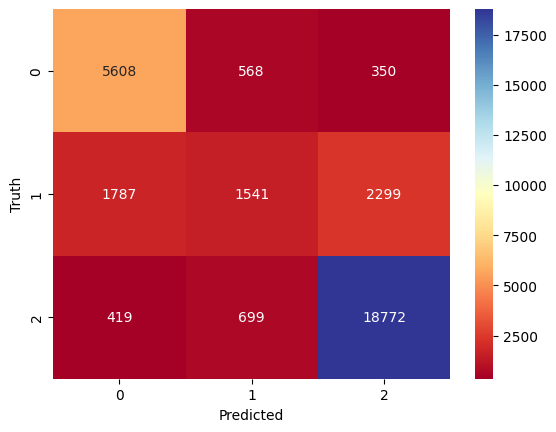

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

y_predicted_logits = trainer.predict(encoded_oversampled_dataset)[0]
y_predicted = np.argmax(y_predicted_logits, axis=1)
y_test_logits = encoded_oversampled_dataset['label']
y_test = np.argmax(y_test_logits, axis=1)
cm = confusion_matrix(y_test, y_predicted)
aac = metric.compute(predictions=y_predicted, references=y_test)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu')
plt.xlabel('Predicted')
plt.ylabel('Truth')
classification_report(y_test, y_predicted, target_names=sentiment_labels.values())

              precision    recall  f1-score   support

    negative       0.72      0.86      0.78      6526
     neutral       0.55      0.27      0.37      5627
    positive       0.88      0.94      0.91     19890

    accuracy                           0.81     32043
   macro avg       0.71      0.69      0.69     32043
weighted avg       0.79      0.81      0.79     32043



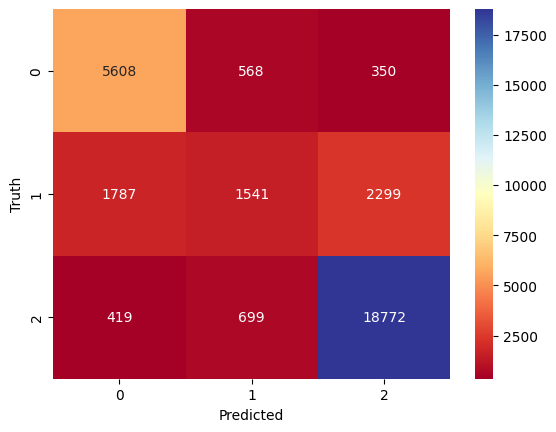

In [20]:
sentiment_labels = {0: "negative", 1: "neutral", 2: "positive"}
sn.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig("confusion_matrix_shoppee.jpg")
report  = classification_report(y_test, y_predicted, target_names=sentiment_labels.values())
print(report)

In [21]:
import pandas as pd

# Split the report string into lines and then by whitespace
report_data = [line.split() for line in report.split('\n') if line.strip()]

report_data[0].insert(0, 'class')
del report_data[-1]
del report_data[-1]
# Create the DataFrame
report_df = pd.DataFrame(report_data)
report_df.to_csv('classification_report_shoppee.csv', index=False)
report_df

,0,1,2,3,4
0,class,precision,recall,f1-score,support
1,negative,0.72,0.86,0.78,6526
2,neutral,0.55,0.27,0.37,5627
3,positive,0.88,0.94,0.91,19890
4,accuracy,0.81,32043,None,None
